# Group Name & numer: DLNK, #26
## Group members:
Natiq Khan (nak9135@nyu.edu)\
David Lopez (dld388@nyu.edu)

Our project is divided into 4 notebooks, each serving its own unique function:
1. Notebook-1: Data retrieval and loading
2. Notebook-2: Data cleaning and standardizing
3. Notebook-3: Exploratory analysis and visualizations
4. **→Notebook-4: Machine Learning and predictions**

We made each notebook in keeping with the principles of **modularization and testing**. As well as **abstraction**, which made it easier to share our work between members seamlessly. 

Data exploration and visualization was done in ***Notebook-3***. Before you proceed with Notebook-4, please ensure you have the following files in your working directory:
1. `final_data.csv`
2. `moneyline.csv`
3. `stats.csv`

# 4.1 Setup

In [1]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score

In [2]:
# Load Documents
doc1_path = "moneyline.csv"
doc2_path = "stats.csv"

df_moneyline = pd.read_csv(doc1_path)
df_stats = pd.read_csv(doc2_path)

# 4.2 Data preprocesssing

Before we can begin our machine learning analysis, we need to transform our data (especially `moneyline.csv` and `stats.csv` for it to be suitable. 

In [3]:
# Transformation 1 – Remove "@", Create Venue
df_moneyline["Venue"] = df_moneyline["Opp"].str.startswith("@").map({True: "Away", False: "Home"})
df_moneyline["Opp"] = df_moneyline["Opp"].str.lstrip("@")

In [4]:
# Transformation 2 – Fix abbreviations
abbrev_fix_doc1 = {
    "SDG": "LAC","STL": "LAR","OAK": "LVR","NE": "NWE",
    "SFO": "SF","NOR": "NO","TAM": "TB","GNB": "GB","KAN": "KC"
}

df_moneyline["Team"] = df_moneyline["Team"].replace(abbrev_fix_doc1)
df_moneyline["Opp"]  = df_moneyline["Opp"].replace(abbrev_fix_doc1)

team_abbrev = {
    "Arizona Cardinals": "ARI","Los Angeles Rams": "LAR","San Francisco 49ers": "SF",
    "Seattle Seahawks": "SEA","Atlanta Falcons": "ATL","Carolina Panthers": "CAR",
    "Tampa Bay Buccaneers": "TB","New Orleans Saints": "NO","Buffalo Bills": "BUF",
    "New England Patriots": "NWE","Miami Dolphins": "MIA","New York Jets": "NYJ",
    "Chicago Bears": "CHI","Green Bay Packers": "GB","Minnesota Vikings": "MIN",
    "Detroit Lions": "DET","Cincinnati Bengals": "CIN","Baltimore Ravens": "BAL",
    "Pittsburgh Steelers": "PIT","Cleveland Browns": "CLE","Dallas Cowboys": "DAL",
    "New York Giants": "NYG","Philadelphia Eagles": "PHI","Washington Commanders": "WAS",
    "Denver Broncos": "DEN","Las Vegas Raiders": "LVR","Kansas City Chiefs": "KC",
    "Los Angeles Chargers": "LAC","Houston Texans": "HOU","Indianapolis Colts": "IND",
    "Jacksonville Jaguars": "JAX","Tennessee Titans": "TEN",
    "St. Louis Rams": "LAR","Washington Redskins": "WAS","Oakland Raiders": "LVR",
    "Washington Football Team": "WAS","San Diego Chargers": "LAC"
}

df_stats["Winner/tie"] = df_stats["Winner/tie"].replace(team_abbrev)
df_stats["Loser/tie"]  = df_stats["Loser/tie"].replace(team_abbrev)

In [5]:
# Transformation 3 – Winner/Loser → Team/Opp rows
pts_cols = [c for c in df_stats.columns if c.startswith("Pts")]
pts_w_col, pts_l_col = pts_cols[0], pts_cols[1]

winner_view = df_stats.copy()
winner_view["Team"] = winner_view["Winner/tie"]
winner_view["Opp"]  = winner_view["Loser/tie"]
winner_view["PtsFor"]     = winner_view[pts_w_col]
winner_view["PtsAgainst"] = winner_view[pts_l_col]
winner_view["YdsFor"]     = winner_view["YdsW"]
winner_view["TOFor"]      = winner_view["TOW"]
winner_view["YdsAgainst"] = winner_view["YdsL"]
winner_view["TOAgainst"]  = winner_view["TOL"]

loser_view = df_stats.copy()
loser_view["Team"] = loser_view["Loser/tie"]
loser_view["Opp"]  = loser_view["Winner/tie"]
loser_view["PtsFor"]     = loser_view[pts_l_col]
loser_view["PtsAgainst"] = loser_view[pts_w_col]
loser_view["YdsFor"]     = loser_view["YdsL"]
loser_view["TOFor"]      = loser_view["TOL"]
loser_view["YdsAgainst"] = loser_view["YdsW"]
loser_view["TOAgainst"]  = loser_view["TOW"]

df_stats_team = pd.concat([winner_view, loser_view], ignore_index=True)
df_stats_team = df_stats_team.drop(columns=["Winner/tie","Loser/tie"])

In [6]:
# Transformation 4 – Create Game#
df_stats_team = df_stats_team.sort_values(["Season","Team","Week"]).reset_index(drop=True)
df_stats_team["G#"] = df_stats_team.groupby(["Season","Team"]).cumcount() + 1

In [7]:
# Transformation 5 - CREATE Week Map using (Season, Team, Opp, G#) for future indexing
week_map = df_stats_team[["Season","Team","Opp","G#","Week"]].copy()

In [8]:
# Transformation 6 – Create Divisional Rivalries
nfl_divisions = {
    "AFC East": ["BUF","MIA","NYJ","NWE"],
    "AFC North": ["BAL","CIN","CLE","PIT"],
    "AFC South": ["HOU","IND","JAX","TEN"],
    "AFC West": ["DEN","KC","LVR","LAC"],
    "NFC East": ["DAL","NYG","PHI","WAS"],
    "NFC North": ["GB","MIN","CHI","DET"],
    "NFC South": ["TB","NO","ATL","CAR"],
    "NFC West": ["SF","SEA","LAR","ARI"]
}

team_to_division = {t: div for div, teams in nfl_divisions.items() for t in teams}
df_moneyline["Team_Div"] = df_moneyline["Team"].map(team_to_division)
df_moneyline["Opp_Div"]  = df_moneyline["Opp"].map(team_to_division)
df_moneyline["DivRivalry"] = (df_moneyline["Team_Div"] == df_moneyline["Opp_Div"]).astype(int)

In [9]:
# Transformation 7 - Merge moneyline.csv and stats.csv
merge_keys = ["Season","Team","Opp","G#"]

DS = df_moneyline.merge(
    df_stats_team,
    on=merge_keys,
    how="left"
)

In [10]:
# Transformation 8 - Secure the Week Column for future indexing
DS = DS.merge(
    week_map,
    on=["Season","Team","Opp","G#"],
    how="left",
    suffixes=("","_weekmap")
)

if "Week_weekmap" in DS.columns:
    DS["Week"] = DS["Week_weekmap"]
    DS = DS.drop(columns=["Week_weekmap"])

DS["Week"] = pd.to_numeric(DS["Week"], errors="coerce")
missing_week = DS["Week"].isna().sum()
print("Missing Week values:", missing_week)

DS = DS.dropna(subset=["Week"]).copy()
DS["Week"] = DS["Week"].astype(int)

Missing Week values: 542


In [11]:
# Transformation 9 - Create Game ID for indexing
DS["game_id"] = (
    DS["Season"].astype(str)
    + "_" +
    DS["Week"].astype(str).str.zfill(2)
    + "_" +
    DS["Team"]
    + "_" +
    DS["Opp"]
)

In [12]:
# Transformation 10 - Create "Game Result" Column
DS["Game Result"] = DS.apply(
    lambda row: "W" if row["PtsFor"] > row["PtsAgainst"] else "L",
    axis=1
)

In [13]:
# Transformation 11 - Create Underdog Column
DS["Underdog"] = DS["Spread"].apply(lambda x: "Y" if x > 0 else "N")

In [14]:
# Transformation 12 - Create Rolling Averages for Team Performance Metrics
stats_cols = ["PtsFor","PtsAgainst","YdsFor","YdsAgainst","TOFor","TOAgainst"]
DS = DS.sort_values(["Season","Team","Week"])

for col in stats_cols:
    DS[f"Avg_{col}"] = (
        DS.groupby(["Season","Team"])[col].transform(lambda x: x.shift().expanding().mean())
    )

In [15]:
# Transformation 13 - Create Rolling Averages for Opponent Team Performance Metrics
opp_cols = ["PtsAgainst","PtsFor","YdsAgainst","YdsFor","TOAgainst","TOFor"]
DS = DS.sort_values(["Season","Opp","Week"])
for col in opp_cols:
    DS[f"Opp_Avg_{col}"] = (
        DS.groupby(["Season","Opp"])[col].transform(lambda x: x.shift().expanding().mean())
    )

In [16]:
# Transformation 14 - Define how many Rest Days the team had
date_cols = [c for c in DS.columns if "date" in c.lower()]
date_col = date_cols[0]

DS = DS.rename(columns={date_col:"Date"})
DS["Date"] = pd.to_datetime(DS["Date"], errors="coerce")
DS = DS.sort_values(["Season","Team","Date"])

DS["Days_Rest"] = DS.groupby(["Season","Team"])["Date"].diff().dt.days
DS["Short_Rest"] = DS["Days_Rest"].apply(lambda x: 1 if pd.notna(x) and x <= 7 else 0)
DS["Long_Rest"]  = DS["Days_Rest"].apply(lambda x: 1 if pd.notna(x) and x >= 10 else 0)

In [17]:
# Transformation 15 - Filter Out Favorite Teams
DS = DS[DS["Underdog"]=="Y"].reset_index(drop=True)

output_path = os.path.join(os.getcwd(), "DS_GA_1007_Machine_Learning")
DS.to_csv(output_path, index=False)
print("Saved CSV:", output_path)

Saved CSV: /Users/knatiq/Desktop/Prog/Project/NFL_underdog_predictor/final/DS_GA_1007_Machine_Learning


# 4.3 ML Feature engineering

Now, we'll adjust `final_data.csv` for it to be merged with our earlier dataframe, and engineer a few more features for our prediction model. 

In [18]:
# Load Document 3 (Play-by-Play Aggregated)

doc3_path = "final_data.csv"
new_df = pd.read_csv(doc3_path)

# Repeat Standardization of Names

team_map = {
    "ARI": "ARI", "ATL": "ATL", "BAL": "BAL", "BUF": "BUF",
    "CAR": "CAR", "CHI": "CHI", "CIN": "CIN", "CLE": "CLE",
    "DAL": "DAL", "DEN": "DEN", "DET": "DET", "GB": "GB",
    "HOU": "HOU", "IND": "IND", "JAX": "JAX", "KC": "KC",
    "LV": "LVR", "LVR": "LVR", "LAC": "LAC", "LAR": "LAR",
    "MIA": "MIA", "MIN": "MIN", "NE": "NWE", "NWE": "NWE",
    "NO": "NO", "NYG": "NYG", "NYJ": "NYJ", "PHI": "PHI",
    "PIT": "PIT", "SEA": "SEA", "SF": "SF", "TB": "TB",
    "TEN": "TEN", "WAS": "WAS"
}

new_df["home_team"] = new_df["home_team"].replace(team_map)
new_df["away_team"] = new_df["away_team"].replace(team_map)

In [19]:
# Transformation 16 - Convert Home/Away into Team/Opp Format

home = new_df.copy()
home["Team"] = home["home_team"]
home["Opp"]  = home["away_team"]

home["PtsFor"]     = home["final_home_score"]
home["PtsAgainst"] = home["final_away_score"]
home["YdsFor"]     = home["home_yards_total"]
home["YdsAgainst"] = home["away_yards_total"]
home["PassPlays"]  = home["home_pass_plays"]
home["RushPlays"]  = home["home_rush_plays"]
home["ExplosivePlays"] = home["home_explosive_plays"]
home["EPA_Total"]  = home["home_epa_total"]
home["EPA_Mean"]   = home["home_epa_mean"]
home["TOFor"]      = home["home_interceptions"] + home["home_fumbles_lost"]
home["TOAgainst"]  = home["away_interceptions"] + home["away_fumbles_lost"]
home["Spread"]     = home["spread_home"]
home["Venue"]      = "Home"

away = new_df.copy()
away["Team"] = away["away_team"]
away["Opp"]  = away["home_team"]

away["PtsFor"]     = away["final_away_score"]
away["PtsAgainst"] = away["final_home_score"]
away["YdsFor"]     = away["away_yards_total"]
away["YdsAgainst"] = away["home_yards_total"]
away["PassPlays"]  = away["away_pass_plays"]
away["RushPlays"]  = away["away_rush_plays"]
away["ExplosivePlays"] = away["away_explosive_plays"]
away["EPA_Total"]  = away["away_epa_total"]
away["EPA_Mean"]   = away["away_epa_mean"]
away["TOFor"]      = away["away_interceptions"] + away["away_fumbles_lost"]
away["TOAgainst"]  = away["home_interceptions"] + away["home_fumbles_lost"]
away["Spread"]     = away["spread_away"]
away["Venue"]      = "Away"

In [20]:
# Transformation 17 - Blend Documentation

new_team_format = pd.concat([home, away], ignore_index=True)

In [21]:
# Transformation 18 - Rename Columns to Match DS Format

new_team_format = new_team_format.rename(columns={
    "season": "Season",
    "week": "Week",
    "game_date": "Date"
})

new_team_format["game_id"] = new_team_format["game_id"].astype(str)

In [22]:
# Transformation 19 - Create Game Number (#G)

new_team_format = new_team_format.sort_values(["Season", "Team", "Week"])
new_team_format["G#"] = new_team_format.groupby(["Season", "Team"]).cumcount() + 1

In [23]:
# Transformation 20 - Merge files

DS = DS.merge(
    new_team_format,
    on="game_id",
    how="left",
    suffixes=("", "_NEW")
)

In [24]:
# Transformation 21 - Team Rolling Averages

rolling_metrics = [
    "PassPlays", "RushPlays", "ExplosivePlays",
    "EPA_Total", "EPA_Mean"
]

DS = DS.sort_values(["Season", "Team", "Date"])
for col in rolling_metrics:
    DS[f"Avg_{col}"] = (
        DS.groupby(["Season", "Team"])[col]
        .transform(lambda x: x.shift().expanding().mean())
    )

In [25]:
# Transformation 22 - Team Rolling Averages (Opposition)

opp_rolls = []
for team in DS["Team"].unique():
    temp = DS[DS["Team"] == team].sort_values(["Season", "Date"])
    
    for col in rolling_metrics:
        temp[f"Opp_Avg_{col}"] = temp[col].shift().expanding().mean()

    opp_rolls.append(temp[["game_id"] + [f"Opp_Avg_{c}" for c in rolling_metrics]])

opp_rolls = pd.concat(opp_rolls, ignore_index=True)

DS = DS.merge(
    opp_rolls,
    on="game_id",
    how="left"
)

In [26]:
# ML READINESS CHECK

team_metrics = [f"Avg_{c}" for c in rolling_metrics]
opp_metrics  = [f"Opp_Avg_{c}" for c in rolling_metrics]

DS["TEAM_Complete"] = DS[team_metrics].notna().all(axis=1)
DS["OPP_Complete"]  = DS[opp_metrics].notna().all(axis=1)
DS["ML_Ready"]      = DS["TEAM_Complete"] & DS["OPP_Complete"]

num_team_ok = DS["TEAM_Complete"].sum()
num_opp_ok  = DS["OPP_Complete"].sum()
num_ml_ok   = DS["ML_Ready"].sum()
total_rows  = len(DS)

print("\n---------------- ML READINESS ----------------")
print(f"Rows with complete TEAM metrics: {num_team_ok} / {total_rows}")
print(f"Rows with complete OPP metrics:  {num_opp_ok} / {total_rows}")
print(f"Rows FULLY ML-ready:             {num_ml_ok} / {total_rows}")
print("------------------------------------------------")


---------------- ML READINESS ----------------
Rows with complete TEAM metrics: 5869 / 10089
Rows with complete OPP metrics:  8651 / 10089
Rows FULLY ML-ready:             5841 / 10089
------------------------------------------------


In [27]:
# Save the merged file

output_path = "DS_GA_1007_Machine_Learning_Final.csv"
DS.to_csv(output_path, index=False)

print("\nSaved merged dataset with rolling averages to:", output_path)


Saved merged dataset with rolling averages to: DS_GA_1007_Machine_Learning_Final.csv


# 4.4 Machine Learning analysis

We will be using a random foreset classifier and use some matchup-difference features we will be creating. We will evaluate our model against the Naive Bayes classifier as our baseline. 

In [28]:
# RANDOM FOREST CLASSIFIER WITH MATCHUP DIFFERENCE FEATURES
# + NAIVE BASELINE CONFUSION MATRIX

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the merged dataset we just saved

df = pd.read_csv("DS_GA_1007_Machine_Learning_Final.csv", low_memory=False)

In [29]:
# 2. Create matchup difference features

df["Diff_Pts"]          = df["Avg_PtsFor"]           - df["Opp_Avg_PtsAgainst"]
df["Diff_YdsFor"]       = df["Avg_YdsFor"]           - df["Opp_Avg_YdsAgainst"]
df["Diff_YdsAllowed"]   = df["Avg_YdsAgainst"]       - df["Opp_Avg_YdsFor"]
df["Diff_TOFor"]        = df["Avg_TOFor"]            - df["Opp_Avg_TOAgainst"]
df["Diff_TOAllowed"]    = df["Avg_TOAgainst"]        - df["Opp_Avg_TOFor"]

df["DivRivalry"]        = df["DivRivalry"]
df["Days_Rest"]         = df["Days_Rest"]
df["Spread"]            = df["Spread"]
df["Avg_PassPlays"]        = df["Avg_PassPlays"]
df["Opp_Avg_PassPlays"]    = df["Opp_Avg_PassPlays"]
df["Avg_RushPlays"]        = df["Avg_RushPlays"]
df["Opp_Avg_RushPlays"]    = df["Opp_Avg_RushPlays"]
df["Avg_ExplosivePlays"]   = df["Avg_ExplosivePlays"]
df["Opp_Avg_ExplosivePlays"] = df["Opp_Avg_ExplosivePlays"]
df["Avg_EPA_Total"]        = df["Avg_EPA_Total"]
df["Opp_Avg_EPA_Total"]    = df["Opp_Avg_EPA_Total"]
df["Avg_EPA_Mean"]         = df["Avg_EPA_Mean"]
df["Opp_Avg_EPA_Mean"]     = df["Opp_Avg_EPA_Mean"]

In [30]:
# 3. Select features

feature_cols = [
    "Diff_Pts","Diff_YdsFor","Diff_YdsAllowed","Diff_TOFor","Diff_TOAllowed",
    "Avg_PassPlays","Avg_RushPlays","Avg_ExplosivePlays","Avg_EPA_Total","Avg_EPA_Mean",
    "Opp_Avg_PassPlays","Opp_Avg_RushPlays","Opp_Avg_ExplosivePlays",
    "Opp_Avg_EPA_Total","Opp_Avg_EPA_Mean",
    "Spread","DivRivalry","Days_Rest"
]

In [31]:
# 4. DROP MISSING + CREATE TARGET

df = df.dropna(subset=feature_cols + ["Game Result"]).copy()
df["Target"] = df["Game Result"].map({"W": 1, "L": 0})

We split our data based on time, so 2005-2013 will be our training set and data from 2014 and 2015 will be our test set. 

In [32]:
# 5. TEMPORAL TRAIN/TEST SPLIT

train_df = df[(df["Season"] >= 2005) & (df["Season"] <= 2013)]
test_df  = df[(df["Season"] >= 2014) & (df["Season"] <= 2015)]

X_train = train_df[feature_cols]
y_train = train_df["Target"]

X_test  = test_df[feature_cols]
y_test  = test_df["Target"]

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 4634
Test size : 1044


In [33]:
# 6. RANDOM FOREST WITH CLASS WEIGHT BALANCING

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=10, n_estimators=300, random_state=42)

In [34]:
# 7. TRAIN/TEST PERFORMANCE

train_pred = rf.predict(X_train)
test_pred  = rf.predict(X_test)

print("\n==================== TRAINING ====================")
print("Accuracy:", accuracy_score(y_train, train_pred))
print(confusion_matrix(y_train, train_pred))
print(classification_report(y_train, train_pred, zero_division=0))

print("\n==================== TEST ====================")
print("Accuracy:", accuracy_score(y_test, test_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, zero_division=0))


==================== TRAINING ====================
Accuracy: 0.667242123435477
[[1847 1323]
 [ 219 1245]]
              precision    recall  f1-score   support

           0       0.89      0.58      0.71      3170
           1       0.48      0.85      0.62      1464

    accuracy                           0.67      4634
   macro avg       0.69      0.72      0.66      4634
weighted avg       0.76      0.67      0.68      4634


==================== TEST ====================
Accuracy: 0.5517241379310345
[[310 382]
 [ 86 266]]
              precision    recall  f1-score   support

           0       0.78      0.45      0.57       692
           1       0.41      0.76      0.53       352

    accuracy                           0.55      1044
   macro avg       0.60      0.60      0.55      1044
weighted avg       0.66      0.55      0.56      1044



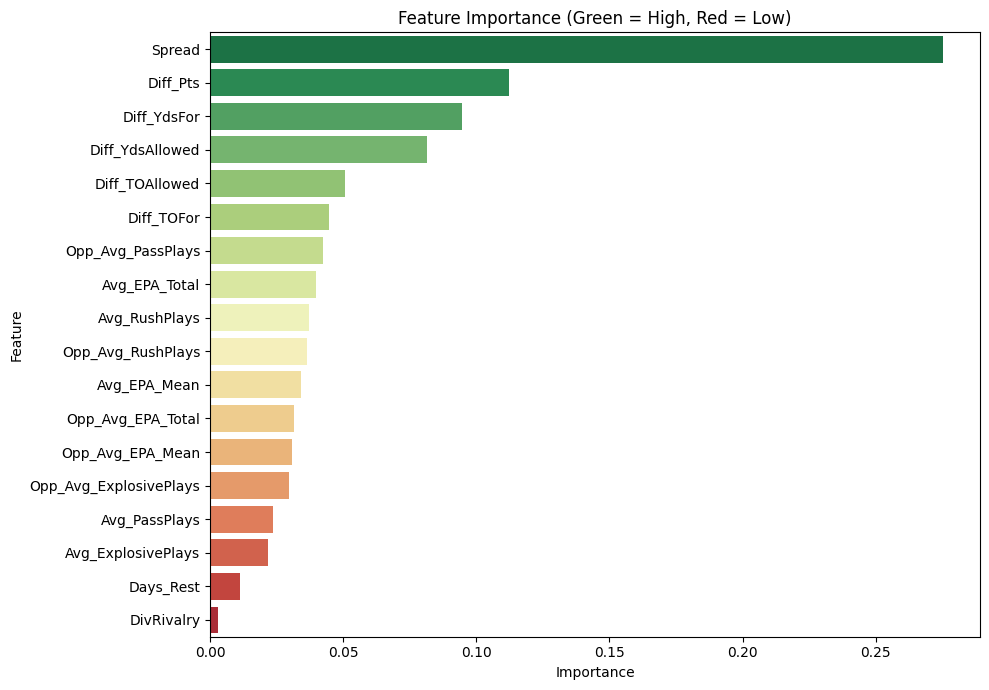

In [35]:
# 8. FEATURE IMPORTANCE

importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 7))

sns.barplot(
    data=importance_df,
    x="Importance",
    y="Feature",
    hue="Feature",
    dodge=False,
    legend=False,
    palette="RdYlGn_r"
)

plt.title("Feature Importance (Green = High, Red = Low)")
plt.tight_layout()
plt.show()

# 4.5 Model evaluation


TRAIN AUC: 0.8476898777818
TEST AUC : 0.6045470966894377


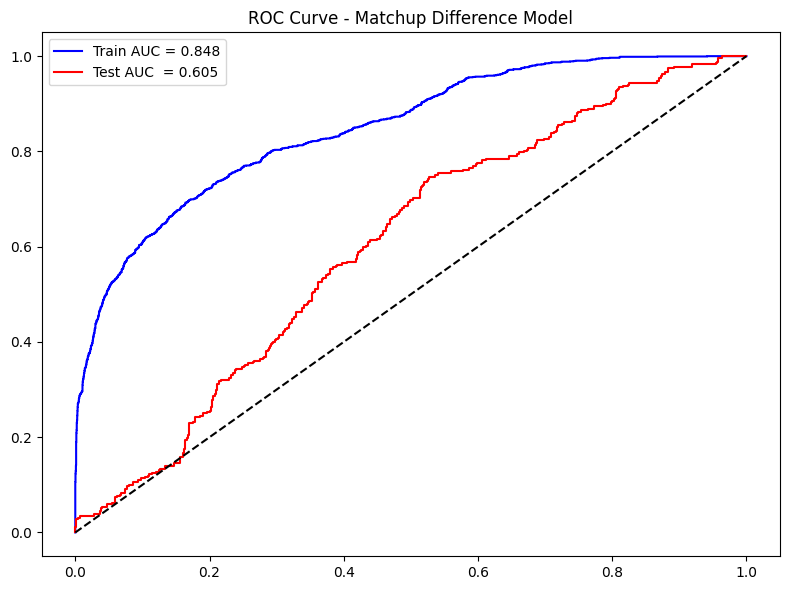

In [36]:
# ROC CURVE & AUC

train_probs = rf.predict_proba(X_train)[:, 1]
test_probs  = rf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
fpr_test,  tpr_test,  _ = roc_curve(y_test, test_probs)

auc_train = auc(fpr_train, tpr_train)
auc_test  = auc(fpr_test,  tpr_test)

print("\nTRAIN AUC:", auc_train)
print("TEST AUC :", auc_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color="blue", label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_test,  tpr_test,  color="red",  label=f"Test AUC  = {auc_test:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.title("ROC Curve - Matchup Difference Model")
plt.tight_layout()
plt.show()

In [ ]:
# Sensitivity, Specificity, Precision

def compute_metrics(y_true, y_pred, label=""):
    """
    Compute and display classification performance metrics.

    This function:
      - Builds a confusion matrix from true and predicted labels.
      - Extracts TN, FP, FN, TP for clearer interpretation.
      - Calculates prevalence, sensitivity, specificity, and precision.
      - Prints a labeled performance summary for quick model comparison.

    Parameters
    ----------
    y_true : array-like
        Ground-truth binary labels (0 = loss, 1 = win).
    y_pred : array-like
        Model-predicted binary labels.
    label : str, optional
        A name (e.g., "TRAIN", "TEST") added to the printed metric header.
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    prevalence  = (TP + FN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision   = TP / (TP + FP) if (TP + FP) > 0 else 0

    print(f"\n======== {label} METRICS ========")
    print("Confusion Matrix:\n", cm)
    print("Prevalence:", prevalence)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("Precision:", precision)

compute_metrics(y_train, train_pred, "TRAIN")
compute_metrics(y_test, test_pred, "TEST")


======== TRAIN METRICS ========
Confusion Matrix:
 [[1847 1323]
 [ 219 1245]]
Prevalence: 0.3159257660768235
Sensitivity: 0.8504098360655737
Specificity: 0.5826498422712934
Precision: 0.4848130841121495

======== TEST METRICS ========
Confusion Matrix:
 [[310 382]
 [ 86 266]]
Prevalence: 0.3371647509578544
Sensitivity: 0.7556818181818182
Specificity: 0.4479768786127168
Precision: 0.4104938271604938


In [38]:
# NAIVE BASELINE: Predict ALL underdogs win

naive_pred = np.ones_like(y_test)

print("\n==================== NAIVE BASELINE ====================")
print("Confusion Matrix (Predict ALL Underdogs Win):")
print(confusion_matrix(y_test, naive_pred))
print(classification_report(y_test, naive_pred, zero_division=0))

compute_metrics(y_test, naive_pred, "NAIVE BASELINE")


==================== NAIVE BASELINE ====================
Confusion Matrix (Predict ALL Underdogs Win):
[[  0 692]
 [  0 352]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       692
           1       0.34      1.00      0.50       352

    accuracy                           0.34      1044
   macro avg       0.17      0.50      0.25      1044
weighted avg       0.11      0.34      0.17      1044


======== NAIVE BASELINE METRICS ========
Confusion Matrix:
 [[  0 692]
 [  0 352]]
Prevalence: 0.3371647509578544
Sensitivity: 1.0
Specificity: 0.0
Precision: 0.3371647509578544


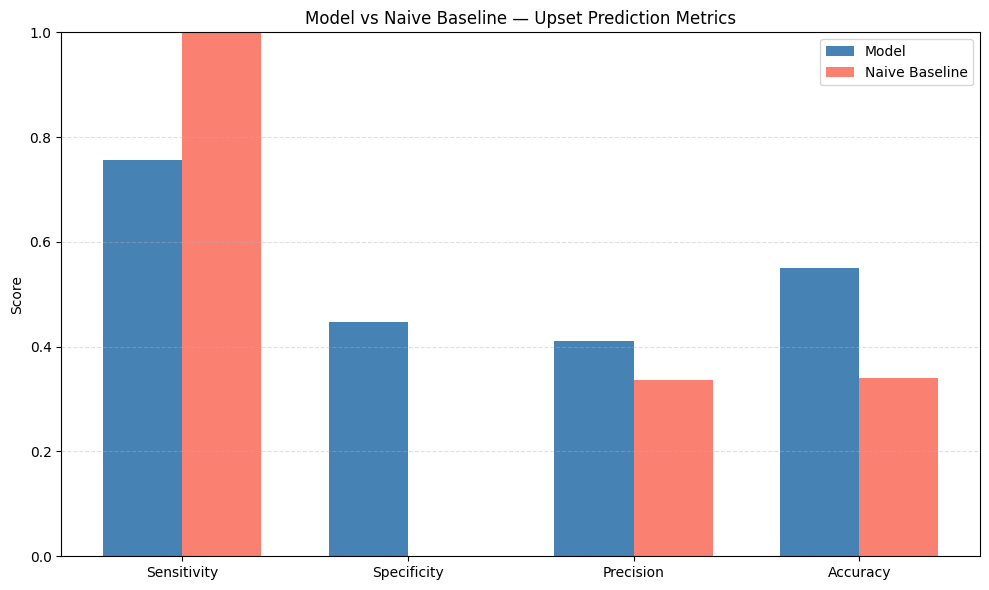

In [39]:
# Metrics from our results

model_metrics = {
    "Sensitivity": 0.7556,
    "Specificity": 0.4479,
    "Precision":   0.4105,
    "Accuracy":    0.55
}

baseline_metrics = {
    "Sensitivity": 1.00,
    "Specificity": 0.00,
    "Precision":   0.3371,
    "Accuracy":    0.34
}


# GRAPHING SETUP
metrics = list(model_metrics.keys())
model_vals = [model_metrics[m] for m in metrics]
base_vals  = [baseline_metrics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, model_vals, width, label="Model", color="steelblue")
plt.bar(x + width/2, base_vals,  width, label="Naive Baseline", color="salmon")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Model vs Naive Baseline — Upset Prediction Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()